<a href="https://colab.research.google.com/github/Befezdow/ai_test/blob/master/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
%matplotlib inline

drive.mount('/content/gdrive')
names_array = ['gender', 'age', 'class1', 'class2', 'class3', *['t{}'.format(i + 1) for i in range(60000)]]
url = '/content/gdrive/My Drive/ML/half.csv'
data = pd.read_csv(url, names=names_array)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Подготавливаем данные, заполняя пропущенные значения медианой.

In [2]:
data = data.fillna(data.median(axis = 0), axis = 0)
data

,gender,age,class1,class2,class3,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20,t21,t22,t23,t24,t25,t26,t27,t28,t29,t30,t31,t32,t33,t34,t35,...,t59961,t59962,t59963,t59964,t59965,t59966,t59967,t59968,t59969,t59970,t59971,t59972,t59973,t59974,t59975,t59976,t59977,t59978,t59979,t59980,t59981,t59982,t59983,t59984,t59985,t59986,t59987,t59988,t59989,t59990,t59991,t59992,t59993,t59994,t59995,t59996,t59997,t59998,t59999,t60000
0,Female,85,3,5.0,NaN,0.003242,0.012132,0.022637,0.010953,-0.024891,-0.032752,-0.031432,-0.042890,-0.048659,-0.037955,-0.026816,-0.017216,-0.014815,-0.024370,-0.027953,-0.037105,-0.046662,-0.052641,-0.054785,-0.054178,-0.034856,-0.023726,-0.036748,-0.031842,-0.021913,-0.038332,-0.045422,-0.044497,-0.042550,-0.038772,-0.043089,-0.055117,-0.062105,-0.062300,-0.062635,...,-0.026842,-0.028914,-0.028548,-0.029272,-0.031896,-0.036031,-0.039794,-0.033593,-0.028113,-0.031301,-0.041995,-0.045999,-0.043968,-0.039291,-0.030942,-0.031698,-0.030754,-0.033479,-0.033446,-0.036413,-0.038551,-0.035920,-0.036477,-0.036518,-0.041184,-0.039042,-0.033992,-0.033940,-0.031528,-0.026267,-0.028246,-0.028318,-0.025569,-0.021279,-0.018593,-0.032023,-0.046202,-0.042003,-0.034466,-0.039000
1,Male,79,9,5.0,NaN,0.012054,0.017017,0.015951,0.020941,0.020960,0.021158,0.021051,0.021062,0.021122,0.021278,0.026533,0.026235,0.016037,0.013366,0.013222,0.008356,0.005556,0.007938,0.008593,0.008398,0.008547,0.008369,0.008677,0.006235,0.000651,-0.001857,-0.001712,-0.007047,-0.009004,-0.012014,-0.019256,-0.019027,-0.019518,-0.018919,-0.020128,...,-0.934049,-0.949376,-0.962051,-0.963686,-0.961742,-0.952030,-0.939060,-0.934415,-0.936366,-0.939326,-0.932011,-0.926725,-0.928331,-0.929013,-0.921389,-0.906309,-0.900787,-0.901273,-0.895911,-0.893740,-0.891627,-0.885869,-0.881577,-0.873489,-0.866113,-0.865862,-0.859139,-0.852907,-0.843380,-0.833925,-0.833698,-0.836701,-0.827418,-0.827810,-0.816231,-0.819793,-0.797862,-0.819597,-0.771195,-0.845490
2,Male,66,3,5.0,NaN,-0.009508,-0.008508,-0.009508,-0.008508,-0.007508,-0.006508,-0.006508,-0.006508,-0.005508,-0.006508,-0.005508,-0.004508,-0.003508,-0.004508,-0.004508,-0.004508,-0.005508,-0.004508,-0.003508,-0.004508,-0.003508,-0.002508,-0.000508,-0.001508,-0.000508,-0.000508,-0.001508,-0.001508,-0.001508,-0.000508,0.000492,0.002492,0.005492,0.006492,0.007492,...,-0.051053,-0.052053,-0.051053,-0.049053,-0.047053,-0.044053,-0.040053,-0.037053,-0.036053,-0.034053,-0.034053,-0.034053,-0.033053,-0.031053,-0.028053,-0.025053,-0.022053,-0.019053,-0.017053,-0.017053,-0.016053,-0.016053,-0.014053,-0.013053,-0.010053,-0.007053,-0.003053,0.001947,0.004947,0.007947,0.009947,0.011947,0.012947,0.015947,0.018947,0.023947,0.027947,0.030947,0.034947,0.037947
3,Male,93,2,5.0,NaN,-0.002271,0.004177,-0.002077,-0.005875,-0.004685,-0.008117,-0.019722,-0.036185,-0.037616,-0.025323,-0.023199,-0.035744,-0.043484,-0.030469,-0.022611,-0.010540,0.004805,0.020337,0.029668,0.017382,0.004737,0.002755,0.014075,0.015677,0.002024,-0.002544,0.000068,0.000271,0.011654,0.022805,0.028631,0.029834,0.030584,0.035327,0.051485,...,-0.117502,-0.208445,-0.254530,-0.270954,-0.254278,-0.223832,-0.205055,-0.179093,-0.157585,-0.127692,-0.089728,-0.074150,-0.056856,-0.038932,-0.024184,-0.016817,-0.014031,-0.011765,-0.022771,-0.023586,-0.013769,-0.004949,-0.003625,-0.013567,-0.019471,-0.015372,-0.021787,-0.028885,-0.028997,-0.021737,-0.013160,-0.006182,-0.003825,-0.002177,-0.001466,-0.006676,-0.011236,-0.016540,-0.016289,-0.022542
4,Male,65,2,5.0,NaN,-0.030600,-0.027425,-0.013923,-0.023743,-0.024572,-0.036078,-0.034740,-0.013670,-0.009571,-0.022441,-0.033034,-0.032663,-0.018181,-0.017317,-0.030576,-0.032829,-0.010305,0.005287,0.006696,-0.002352,-0.005559,-0.005361,-0.008254,0.002175,0.007531,0.002662,0.000376,-0.007697,-0.016977,-0.009894,-0.000388,-0.012127,-0.007840,-0.002470,-0.005233,...,1.016910,0.710028,0.406775,0.104651,-0.181270,-0.432753,-0.645005,-0.816434,-0.952654,-1.038151,-1.073172,-1.060904,-1.006902,-0.914312,-0.803500,-0.697

Осуществляем аугментацию данных. На каждый датчик идет по 5000 записей. Разбиваем так, чтобы на каждый приходилось по 100, тем самым размножая данные.

In [0]:
# когда во фрейме всего одно отведение
count_of_iterations = 100
needed_per_abduction = 100

non_sliceable_columns = data.iloc[:,0:5]
sliceable_columns = data.iloc[:,5:]
sliceable_columns_count = sliceable_columns.shape[1]

new_data = pd.DataFrame()
for i in range(count_of_iterations):
  random_position = random.randint(0, sliceable_columns_count - needed_per_abduction)
  columns_slice = sliceable_columns.iloc[:, random_position:random_position + needed_per_abduction]
  completed_slice = pd.concat([non_sliceable_columns.copy(), columns_slice.copy()], axis=1, sort=False, ignore_index=True)
  new_data = pd.concat([new_data, completed_slice], axis=0, sort=False, ignore_index=True)

new_data.columns = ['gender', 'age', 'class1', 'class2', 'class3', *['t{}'.format(i + 1) for i in range(needed_per_abduction)]]
new_data

In [5]:
# когда во фрейме произвольное кол-во отведений
count_of_iterations = 100
abductions_count = 12
needed_per_abduction = 100

non_sliceable_columns = data.iloc[:,0:5]
sliceable_columns = data.iloc[:,5:]
sliceable_columns_count = sliceable_columns.shape[1]
per_abduction = int(sliceable_columns_count / abductions_count)

new_data = pd.DataFrame()
for i in range(count_of_iterations):
  random_position = random.randint(0, per_abduction - needed_per_abduction)

  total_columns_slice = pd.DataFrame()
  for j in range(abductions_count):
    start_column = j * per_abduction + random_position
    end_column = j * per_abduction + random_position + needed_per_abduction
    columns_slice = sliceable_columns.iloc[:, start_column : end_column]
    total_columns_slice = pd.concat([total_columns_slice, columns_slice.copy()], axis=1, sort=False, ignore_index=True)
  
  completed_slice = pd.concat([non_sliceable_columns.copy(), total_columns_slice], axis=1, sort=False, ignore_index=True)
  new_data = pd.concat([new_data, completed_slice], axis=0, sort=False, ignore_index=True)

new_data.columns = ['gender', 'age', 'class1', 'class2', 'class3', *['t{}_{}'.format(i + 1, j + 1) for i in range(abductions_count) for j in range(needed_per_abduction)]]
new_data

,gender,age,class1,class2,class3,t1_1,t1_2,t1_3,t1_4,t1_5,t1_6,t1_7,t1_8,t1_9,t1_10,t1_11,t1_12,t1_13,t1_14,t1_15,t1_16,t1_17,t1_18,t1_19,t1_20,t1_21,t1_22,t1_23,t1_24,t1_25,t1_26,t1_27,t1_28,t1_29,t1_30,t1_31,t1_32,t1_33,t1_34,t1_35,...,t12_61,t12_62,t12_63,t12_64,t12_65,t12_66,t12_67,t12_68,t12_69,t12_70,t12_71,t12_72,t12_73,t12_74,t12_75,t12_76,t12_77,t12_78,t12_79,t12_80,t12_81,t12_82,t12_83,t12_84,t12_85,t12_86,t12_87,t12_88,t12_89,t12_90,t12_91,t12_92,t12_93,t12_94,t12_95,t12_96,t12_97,t12_98,t12_99,t12_100
0,Female,85,3,5.0,NaN,-0.016456,-0.017057,-0.025023,-0.027278,-0.026192,-0.027314,-0.040464,-0.036028,-0.008958,0.004868,0.001376,0.006015,0.006006,-0.004612,-0.004691,0.000808,0.003859,0.000040,-0.006812,-0.013696,-0.011772,-0.004309,-0.004645,-0.002239,0.005675,0.015188,0.025592,0.045953,0.042873,0.021069,0.011677,0.015200,0.048486,0.067000,0.057968,...,-0.005726,-0.009002,-0.016023,-0.016056,-0.014613,-0.010935,-0.008248,-0.008899,-0.006184,-0.001302,-0.001047,-0.000876,-0.002835,-0.003791,-0.003255,-0.004207,-0.007775,-0.009569,-0.010095,-0.003804,-0.003473,-0.004002,-0.006461,-0.003979,-0.003575,-0.001712,-0.000766,-0.001191,-0.000739,-0.003307,-0.008449,-0.006307,-0.001186,-0.001201,-0.000644,-0.003215,-0.003055,-0.008693,-0.021359,-0.023280
1,Male,79,9,5.0,NaN,-0.011352,-0.016780,-0.014232,-0.009782,-0.006679,-0.004021,-0.009647,-0.011277,-0.007507,-0.011536,-0.016592,-0.014473,-0.009366,-0.009324,-0.008910,-0.009642,-0.006414,-0.004510,-0.006947,-0.004241,0.006186,-0.001305,-0.004771,-0.001588,-0.004451,-0.006255,-0.009458,-0.003926,-0.006776,-0.009434,-0.008693,-0.004501,-0.004319,-0.001687,0.001305,...,-0.072159,-0.077305,-0.082395,-0.085341,-0.082385,-0.077624,-0.077328,-0.076805,-0.074311,-0.077281,-0.080280,-0.077439,-0.071786,-0.062300,-0.051624,-0.037446,-0.026861,-0.017136,-0.013968,-0.015008,-0.019286,-0.024238,-0.014661,0.016040,0.073160,0.154555,0.244873,0.338028,0.436595,0.547662,0.678942,0.828011,0.981905,1.129972,1.261174,1.366652,1.425230,1.382580,1.266107,1.110859
2,Male,66,3,5.0,NaN,0.036492,0.034492,0.033492,0.033492,0.031492,0.032492,0.030492,0.028492,0.028492,0.026492,0.025492,0.025492,0.022492,0.021492,0.021492,0.020492,0.018492,0.017492,0.016492,0.012492,0.011492,0.008492,0.007492,0.005492,0.004492,0.002492,0.001492,0.000492,-0.001508,-0.002508,-0.003508,-0.006508,-0.007508,-0.006508,-0.007508,...,-0.050053,-0.051053,-0.051053,-0.051053,-0.052053,-0.052053,-0.052053,-0.052053,-0.052053,-0.052053,-0.050053,-0.049053,-0.047053,-0.045053,-0.043053,-0.041053,-0.039053,-0.037053,-0.036053,-0.035053,-0.035053,-0.034053,-0.033053,-0.032053,-0.031053,-0.030053,-0.028053,-0.027053,-0.027053,-0.027053,-0.027053,-0.027053,-0.027053,-0.026053,-0.025053,-0.024053,-0.022053,-0.021053,-0.020053,-0.020053
3,Male,93,2,5.0,NaN,-0.002535,-0.004632,-0.005224,0.001845,0.005010,-0.002348,-0.005861,-0.000775,0.010194,0.010036,0.006982,0.007725,0.014520,0.024894,0.027670,0.017939,0.002164,-0.003058,0.003017,0.002573,0.007027,0.022793,0.035725,0.047955,0.055234,0.053452,0.059403,0.057624,0.050729,0.062390,0.070827,0.073135,0.070686,0.064819,0.065723,...,0.013896,0.010605,0.021424,0.031563,0.031153,0.029601,0.020958,0.014013,0.013242,0.009148,0.008568,0.008426,0.003729,0.005800,0.003774,0.000767,0.000837,-0.003573,-0.004004,-0.003815,-0.005784,-0.006652,-0.006671,-0.011395,-0.010413,-0.002431,0.006605,0.011171,0.006483,0.006017,0.006446,0.003963,0.005636,0.005498,0.005758,0.009367,0.006144,0.001341,0.003330,0.008467
4,Male,65,2,5.0,NaN,-0.038161,-0.030965,-0.017669,-0.014840,-0.025182,-0.022537,-0.013410,-0.014574,-0.013309,-0.009940,-0.034613,-0.061376,-0.070716,-0.058337,-0.027267,-0.013492,-0.042655,-0.051271,-0.044887,-0.058497,-0.061168,-0.048091,-0.040901,-0.037720,-0.030257,-0.032146,-0.028391,-0.035132,-0.037891,-0.042480,-0.052607,-0.050946,-0.034869,-0.008440,-0.009828,...,0.012853,0.011208,0.016042,0.021107,0.025716,0.026206,0.025990,0.028000,0.026945,0.018459,0.018268,0.021284,0.014013,0.008337,0.00522

In [0]:
data = new_data

Выкидываем лишние классовые признаки, а затем осуществляем векторизацию и нормализацию данных.

In [8]:
# убираем лишние классовые признаки
data = data.drop('class2', axis = 1)
data = data.drop('class3', axis = 1)

#собираем числовые колонки
numerical_columns = [c for c in data.columns if data[c].dtype.name != 'object' and c != 'class1']

# векторизируем колонку gender
data.at[data['gender'] == 'Male', 'gender'] = 0
data.at[data['gender'] == 'Female', 'gender'] = 1

# нормализуем числовые атрибуты
data_numerical = data[numerical_columns]
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)
data[numerical_columns] = data_numerical

data

,gender,age,class1,t1_1,t1_2,t1_3,t1_4,t1_5,t1_6,t1_7,t1_8,t1_9,t1_10,t1_11,t1_12,t1_13,t1_14,t1_15,t1_16,t1_17,t1_18,t1_19,t1_20,t1_21,t1_22,t1_23,t1_24,t1_25,t1_26,t1_27,t1_28,t1_29,t1_30,t1_31,t1_32,t1_33,t1_34,t1_35,t1_36,t1_37,...,t12_61,t12_62,t12_63,t12_64,t12_65,t12_66,t12_67,t12_68,t12_69,t12_70,t12_71,t12_72,t12_73,t12_74,t12_75,t12_76,t12_77,t12_78,t12_79,t12_80,t12_81,t12_82,t12_83,t12_84,t12_85,t12_86,t12_87,t12_88,t12_89,t12_90,t12_91,t12_92,t12_93,t12_94,t12_95,t12_96,t12_97,t12_98,t12_99,t12_100
0,1,1.177856,3,-0.104493,-0.127937,-0.184355,-0.200493,-0.193157,-0.201105,-0.294678,-0.262677,-0.069790,0.029065,0.004702,0.038754,0.039380,-0.036562,-0.036607,0.003828,0.026776,-0.001792,-0.049760,-0.099809,-0.085815,-0.031660,-0.033796,-0.016400,0.032442,0.089545,0.185343,0.275417,0.312321,0.153952,0.085866,0.112299,0.356973,0.493504,0.427749,0.255364,0.094104,...,-0.016039,-0.026967,-0.050760,-0.050455,-0.044937,-0.031953,-0.022716,-0.024891,-0.015452,0.000476,0.002310,0.002856,-0.003938,-0.007154,-0.006399,-0.008745,-0.021530,-0.028413,-0.030395,-0.010350,-0.010212,-0.013011,-0.022138,-0.014198,-0.013025,-0.007501,-0.004825,-0.005614,-0.003713,-0.011707,-0.027774,-0.020068,-0.001733,-0.000811,0.002189,-0.005720,-0.004743,-0.023360,-0.064201,-0.072811
1,0,0.808699,9,-0.074155,-0.125967,-0.107676,-0.076100,-0.054162,-0.035059,-0.074948,-0.086263,-0.059447,-0.087873,-0.123471,-0.107761,-0.070945,-0.070490,-0.067071,-0.071858,-0.047795,-0.029225,-0.050745,-0.031124,0.044542,-0.009862,-0.034709,-0.011668,-0.028610,-0.039751,-0.069492,-0.025647,-0.049601,-0.068842,-0.063281,-0.032276,-0.030965,-0.011270,0.011201,0.007440,0.007439,...,-0.232039,-0.260205,-0.277749,-0.287698,-0.277142,-0.260564,-0.259719,-0.258093,-0.249564,-0.248432,-0.270263,-0.260693,-0.241414,-0.208802,-0.158313,-0.123166,-0.087146,-0.054375,-0.043030,-0.048582,-0.064023,-0.081744,-0.049932,0.053518,0.246107,0.495405,0.784604,1.135233,1.466763,1.842652,2.184955,2.800008,3.328539,3.838163,4.289262,4.651708,4.854020,4.492794,4.115833,3.790376
2,0,0.008860,3,0.210181,0.238677,0.231454,0.231566,0.217733,0.225221,0.211246,0.197204,0.197141,0.183212,0.176736,0.178047,0.157708,0.151387,0.152449,0.146391,0.132988,0.103411,0.119582,0.090429,0.083056,0.061232,0.054322,0.039785,0.025312,0.012992,0.010122,0.001021,-0.011197,-0.018252,-0.025314,-0.047005,-0.054389,-0.046695,-0.053582,-0.060440,-0.053063,...,-0.160162,-0.170562,-0.170561,-0.170290,-0.173216,-0.172906,-0.173003,-0.173089,-0.173076,-0.165783,-0.166277,-0.162981,-0.156230,-0.149361,-0.131394,-0.135583,-0.129061,-0.122705,-0.115070,-0.116980,-0.117678,-0.115082,-0.112273,-0.109160,-0.105819,-0.098710,-0.092521,-0.092592,-0.092189,-0.091627,-0.087662,-0.090190,-0.089359,-0.085154,-0.080742,-0.076568,-0.069371,-0.063481,-0.059961,-0.061817
3,0,1.670065,2,-0.021756,-0.039572,-0.043662,0.006559,0.029096,-0.023139,-0.047957,-0.011404,0.066720,0.065903,0.044696,0.050986,0.100492,0.175880,0.197055,0.127897,0.014473,-0.020469,0.021661,0.018376,0.050645,0.165005,0.259290,0.348358,0.331263,0.320273,0.431164,0.345867,0.369593,0.455755,0.518946,0.537457,0.520065,0.477476,0.484757,0.646552,0.697637,...,0.047762,0.039985,0.077307,0.112597,0.111868,0.107001,0.077486,0.053793,0.051304,0.034712,0.035387,0.034875,0.018670,0.025902,0.015675,0.008378,0.008075,-0.007846,-0.010526,-0.010388,-0.018077,-0.022013,-0.022848,-0.039284,-0.036119,-0.009814,0.018862,0.035961,0.020573,0.019674,0.020170,0.014648,0.021375,0.021923,0.023940,0.037056,0.026552,0.009211,0.015956,0.035331
4,0,-0.052666,2,-0.233485,-0.226843,-0.132096,-0.112061,-0.185962,-0.167053,-0.101781,-0.109760,-0.100802,-0.076492,-0.252030,-0.443184,-0.511265,-0.423380,-0.199613,-0.099742,-0.310845,-0.311111,-0.326442,-0.425245,-0.444376,-0.349375,-0.297011,-0.274236,-0.184208,-0.195873,-0.207145,-0.214003,-0.276421,-0.310201,-0.384809,-0.373118,-0.255397,-0.060892,-0.070639,-0.242262,-0.318207,...,0.044370,0.042044,0.058902,0.076795,0.093238,0.095365,0.094751,0.10182

Разбиваем данные на входы и выходы.

In [0]:
# бьем данные на входы и выходы
x = data.drop('class1', axis = 1)
y = data['class1']

Разбиваем данные на обучающую и тестовую выборки.

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

n_train, _ = x_train.shape 
n_test,  _ = x_test.shape 

print('Train dataset size: {}'.format(n_train))
print('Test dataset size: {}'.format(n_test))

Train dataset size: 87500
Test dataset size: 37500


Обучаем случайные леса на этих данных. В качестве гиперпараметра рассматриваем количество деревьев в лесе. Берем значения от 10 до 110 с шагом 10. В процессе подсчитываем ошибки на тренировочных и тестовых данных, а также OOB ошибку.

In [12]:
from sklearn import ensemble

estimators_number_list = list(np.arange(10, 111, 10))
train_error_list = []
test_error_list = []
oob_error_list = []
for estimators_number in estimators_number_list:
  rf_model = ensemble.RandomForestClassifier(n_estimators=estimators_number, oob_score = True)
  rf_model.fit(x_train, y_train)

  train_error = np.mean(rf_model.predict(x_train) != y_train)
  test_error  = np.mean(rf_model.predict(x_test) != y_test)
  oob_error = 1 - rf_model.oob_score_

  train_error_list.append(train_error)
  test_error_list.append(test_error)
  oob_error_list.append(oob_error)

  print(train_error, test_error, oob_error)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.01808 0.45253333333333334 0.5525142857142857


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.011897142857142858 0.40653333333333336 0.48061714285714285
0.01144 0.39194666666666667 0.45227428571428574
0.011394285714285714 0.37933333333333336 0.4282057142857143
0.011382857142857142 0.3713066666666667 0.4142971428571428
0.011382857142857142 0.36666666666666664 0.4042514285714286
0.011382857142857142 0.36317333333333335 0.3978285714285714
0.011371428571428572 0.3579466666666667 0.3902285714285715
0.011371428571428572 0.3590933333333333 0.38654857142857146
0.011371428571428572 0.36032 0.38566857142857147
0.011371428571428572 0.356 0.3808571428571429


Отрисуем графики ошибок.

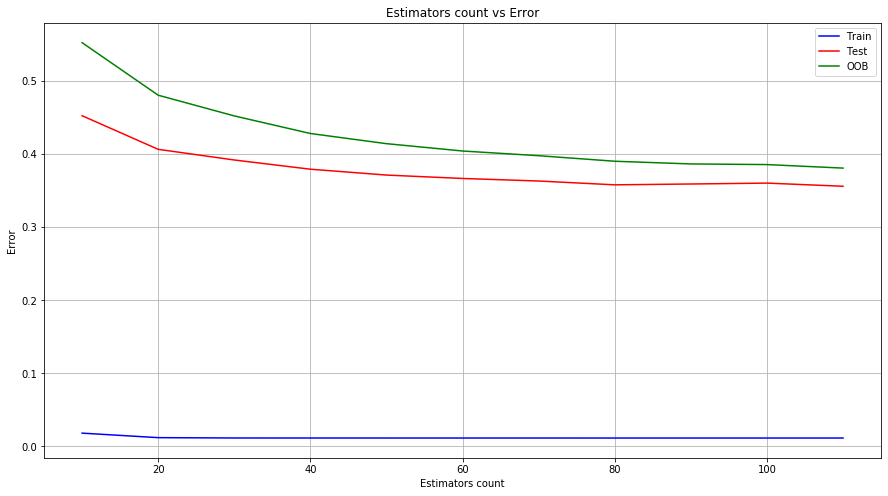

In [13]:
plt.figure(figsize = (15, 8))
plt.plot(estimators_number_list, train_error_list, label = 'Train', color = 'blue')
plt.plot(estimators_number_list, test_error_list, label = 'Test', color = 'red')
plt.plot(estimators_number_list, oob_error_list, label = 'OOB', color = 'green')

plt.xlabel('Estimators count')
plt.ylabel('Error')
plt.title('Estimators count vs Error')
plt.legend()
plt.grid()

Можно заметить тенденцию, что с ростом количества деревьев значения всех ошибок уменьшаются. Наилучший результат получается при кол-ве деревьев в 110 штук. При этом значении ошибка на тестовых данных составляет примерно 35.6%, а OOB ошибка - 38.08%.

Далее применим градиентный бустинг деревьев решений. Обрежем кол-во данных, так как при их большом количестве требует также большое количество времени для обучения моделей.

In [25]:
small_data = data.iloc[0:7000,:]

x = small_data.drop('class1', axis = 1)
y = small_data['class1']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

n_train, _ = x_train.shape 
n_test,  _ = x_test.shape 

print('Train dataset size: {}'.format(n_train))
print('Test dataset size: {}'.format(n_test))

Train dataset size: 4900
Test dataset size: 2100


В качестве гиперпараметра также рассматриваем количество деревьев в лесе. Берем значения от 10 до 110 с шагом 10.

In [26]:
estimators_number_list = list(np.arange(10, 111, 10))
train_error_list = []
test_error_list = []
for estimators_number in estimators_number_list:
  gbt_model = ensemble.GradientBoostingClassifier(n_estimators = estimators_number, subsample=0.5)
  gbt_model.fit(x_train, y_train)

  train_error = np.mean(y_train != gbt_model.predict(x_train))
  test_error = np.mean(y_test != gbt_model.predict(x_test))

  train_error_list.append(train_error)
  test_error_list.append(test_error)

  print(err_train, err_test)

0.5255102040816326 0.5885714285714285
0.4710204081632653 0.570952380952381
0.43 0.569047619047619
0.4083673469387755 0.5604761904761905
0.3653061224489796 0.5628571428571428
0.3479591836734694 0.5566666666666666
0.30979591836734693 0.5523809523809524
0.2795918367346939 0.5452380952380952
0.2624489795918367 0.5433333333333333
0.2330612244897959 0.5571428571428572
0.2036734693877551 0.5452380952380952


Отрисуем графики ошибок.

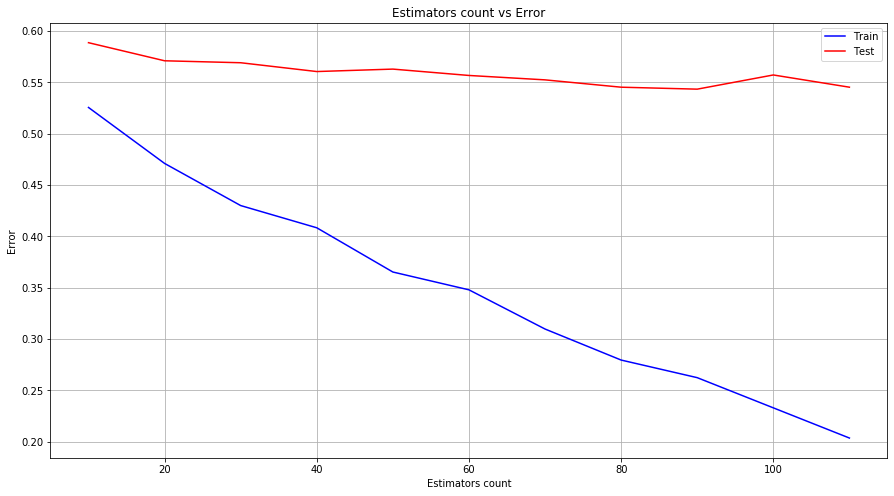

In [43]:
plt.figure(figsize = (15, 8))
plt.plot(estimators_number_list, train_error_list, label = 'Train', color = 'blue')
plt.plot(estimators_number_list, test_error_list, label = 'Test', color = 'red')

plt.xlabel('Estimators count')
plt.ylabel('Error')
plt.title('Estimators count vs Error')
plt.legend()
plt.grid()

Здесь также заметна тенденция, что с ростом количества деревьев значения всех ошибок уменьшаются. Наилучший результат получается при кол-ве деревьев в 90 штук. При этом значении ошибка на тестовых данных составляет примерно 54.33%. Само собой здесь заметно недообучение, так как ошибка на тренировочных данных в RandomForest и GBT сильно разнятся. Очевидно, что при увеличении числа данных, можно значительно улучшить результаты. Однако это потребует значительного кол-ва времени и/или мощностей оборудования. 
(Есть предложение воспользоваться для этого кластером вышки, который мы настраивали совместно с В. В. Крыловым, однако для получения доступа к jupiter hub на нем потребуется время)

Исходя из предыдущих опытов можно сказать, что деревья на данный момент дают минимальную ошибку в предсказаниях. Однако стоит учесть, что в этой лабораторной работе я применил интервальную аугментацию, которой не было в предыдущих. Ввиду этого, реальные результаты могут отличаться незначительно, особенно в сравнении с глубокими нейронными сетями.